In [1]:
import numpy as np
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from warnings import filterwarnings
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_percentage_error as mape
from tqdm import tqdm

filterwarnings('ignore')

from pupil_detection import IrisLM, IrisBlock
from utils import pad_image

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [6]:
device = "cpu"

In [66]:
model_path = "./weights/irislandmarks.pth"
pretrained_model = IrisLM()
weights = torch.load(model_path)
pretrained_model.load_state_dict(weights)

<All keys matched successfully>

In [105]:
class FineTuneModel(nn.Module):
    def __init__(self, pretrained_model: nn.Module):
        super(FineTuneModel, self).__init__()
        self.backbone = pretrained_model.backbone
        self.regression_head = nn.Sequential(
            IrisBlock(128, 128), IrisBlock(128, 128),
            IrisBlock(128, 128, stride=2),
            IrisBlock(128, 128), IrisBlock(128, 128),
            IrisBlock(128, 128, stride=2),
            IrisBlock(128, 128), IrisBlock(128, 128),
        )
        self.features_dim = 128 * 5 * 5
        self.fc = nn.Linear(self.features_dim + 1, 2)

        
    def forward(self, x, which_eye):
        x = self.backbone(x)
        x = self.regression_head(x)
        x = x.view(-1, self.features_dim)
        x = torch.concat([x, which_eye], axis = 1)
        x = self.fc(x)
        return x

In [68]:
model = FineTuneModel(pretrained_model).to(device)

In [69]:
rand_img = (np.random.randint(0, 255, (64, 64, 3)) / 255.)
x = torch.from_numpy(rand_img).permute((2, 0, 1)).unsqueeze(0).type(torch.float32).to(device)
ind = torch.from_numpy(np.array([1])).unsqueeze(0).type(torch.float32).to(device)

In [70]:
model(x, ind)

tensor([[-1.0863,  0.2976]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [90]:
from typing import List, Optional

class GazeDetectionDataset(Dataset):
    """Gaze detection dataset."""

    def __init__(
        self,
        data: pd.DataFrame,
        transform_list: Optional[List]= None,
        to_tensors: bool = False,
        device: str = "cpu",
    ):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = data.copy()
        self.to_tensors = to_tensors
        transform_list_ = transform_list.copy()
        if to_tensors:
            transform_list_.append(ToTensorV2())
        self.transform = A.Compose(transform_list_)
        self.device = torch.device(device)


    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        row = self.df.iloc[idx]
        img_name = row['paths']
        try:
            image = cv2.imread(img_name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image / 255.
        except Exception:
            raise Exception(f"Image {img_name} failed loading")
        coordinates = row[['x_normalized', 'y_normalized']].values.astype(np.float32)
        ind = row[['if_left']].values.astype(np.float32)
        if self.transform:
            image = self.transform(image = image)['image']
            if self.to_tensors:
                coordinates = torch.from_numpy(coordinates).to(self.device)
                ind = torch.from_numpy(ind).to(self.device)
                image = image.type(torch.float32).to(self.device)
            
        sample = {'image': image, 'coordinates': coordinates, 'indicator': ind}
        return sample

In [72]:
df_val = pd.read_csv("./eyes_val.csv")

In [73]:
trans_list = []

0 (192, 192, 3) (2,)
[1.]

1 (192, 192, 3) (2,)
[0.]

2 (192, 192, 3) (2,)
[1.]

3 (192, 192, 3) (2,)
[0.]



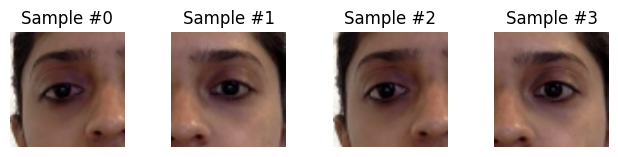

In [74]:
face_dataset = GazeDetectionDataset(data=df_val, transform_list=trans_list)

fig = plt.figure()

for i, sample in enumerate(face_dataset):
    print(i, sample['image'].shape, sample['coordinates'].shape)
    print(sample['indicator'])
    print()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['image'])
    if i == 3:
        plt.show()
        break

In [75]:
face_dataset = GazeDetectionDataset(data = df_val, transform_list=trans_list, to_tensors=True, device=device)

In [76]:
for i, sample in enumerate(face_dataset):
    print(i, sample['image'].size(), sample['coordinates'].size(), sample['indicator'].size())
    if i == 3:
        break

0 torch.Size([3, 192, 192]) torch.Size([2]) torch.Size([1])
1 torch.Size([3, 192, 192]) torch.Size([2]) torch.Size([1])
2 torch.Size([3, 192, 192]) torch.Size([2]) torch.Size([1])
3 torch.Size([3, 192, 192]) torch.Size([2]) torch.Size([1])


In [77]:
def train(model: FineTuneModel, dataloader_train: DataLoader):
    total_loss = 0.0
    model.train()
    preds_list = []
    labels_list = []
    for i, data in enumerate(dataloader_train):
        inputs, labels, ind = data['image'], data['coordinates'], data['indicator']
        optimizer.zero_grad()
        outputs = model(inputs, ind)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        preds_list += outputs.cpu().detach().tolist()
        labels_list += labels.cpu().detach().tolist()
        total_loss += loss.cpu().item()

    loss = total_loss / (i + 1)
    mape_value = mape(labels_list, preds_list)
    return loss, mape_value

In [78]:
def eval(model: FineTuneModel, dataloader_val: DataLoader):
    total_loss = 0.0
    model.eval()
    preds = []
    preds_list = []
    labels_list = []
    for i, data in enumerate(dataloader_val):
        inputs, labels, ind = data['image'], data['coordinates'], data['indicator']
        with torch.no_grad():
            outputs = model(inputs, ind)
        loss = criterion(outputs, labels)
        total_loss += loss.cpu().item()
        preds_list += outputs.cpu().detach().tolist()
        labels_list += labels.cpu().detach().tolist()
        
    loss = total_loss / (i + 1)
    mape_value = mape(labels_list, preds_list)
    return loss, mape_value

In [122]:
NUM_SAMPLES = None
BATCH_SIZE = 1024
LEARNING_RATE = 8e-5
REDUCE_FACTOR = 0.5
PATIENCE = 2
NUM_EPOCHS = 20
WEIGHT_DECAY = 1e-4
CHECKPOINTS_PATH = "./checkpoints/"
EXPERIMENT_NAME = "eyes_less_data_corrected"

In [123]:
test_df = pd.read_csv("./eyes_test.csv")
val_df = pd.read_csv("./eyes_val.csv")
train_df = pd.read_csv("eyes_train.csv")

In [124]:
dataset_train = GazeDetectionDataset(data = train_df, transform_list=trans_list, to_tensors=True, device=device)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0)
dataset_val = GazeDetectionDataset(data = val_df, transform_list=trans_list, to_tensors=True, device=device)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0)

In [125]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [126]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

experiment = Experiment(
  api_key="4qtNKAjcucKnOrwC4pRvPaHRv",
  project_name="tweakle-gaze-detection",
  workspace="kmisterios"
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kmisterios/tweakle-gaze-detection/ca2f4c49bf22410c87dbaba1d427a47d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     best_model_epoch : 0
COMET INFO:     epoch [2]        : (0, 1)
COMET INFO:     lr               : 0.0003
COMET INFO:     rmse_train [2]   : (0.26569874839831703, 0.3139387637580911)
COMET INFO:     rmse_val [2]     : (0.2535187873770209, 0.30505851787679333)
COMET INFO:     train_mape [2]   : (1.2480109218442337, 1.471956874667026)
COMET INFO:     val_mape [2]     : (1.1531256051580114, 1.2152

In [127]:
experiment.set_name(f"{EXPERIMENT_NAME}")

In [128]:
model = FineTuneModel(pretrained_model).to(device)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, factor= REDUCE_FACTOR, patience=PATIENCE)

In [129]:
hyper_params = {
    "learning_rate": LEARNING_RATE,
    "batch_size": BATCH_SIZE,
    "reduce_factor": REDUCE_FACTOR,
    "patience": PATIENCE,
    "num_epochs": NUM_EPOCHS,
    "num_samples": NUM_SAMPLES,
    "optimizer": optimizer.__str__(),
    "scheduler": scheduler.__str__(),
    "gradient_clip": True,
    "experiment_name": EXPERIMENT_NAME,
}
experiment.log_parameters(hyper_params)

In [130]:
val_loss_min = np.inf
epoch_save = None

for epoch in range(NUM_EPOCHS):
    train_loss, train_mape = train(model, dataloader_train)
    val_loss, val_mape = train(model, dataloader_val)
    scheduler.step(val_loss)
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    if val_loss_min > val_loss:
        val_loss_min = val_loss
        torch.save(model.state_dict(), os.path.join(CHECKPOINTS_PATH, f"best_{EXPERIMENT_NAME}.pt"))
        epoch_save = epoch

    print()
    print(f'Epoch: {epoch}: Train loss: {round(train_loss, 3)}; Val loss: {round(val_loss, 3)};')
    if epoch_save is not None:
        print(f'Best model saved on epoch {epoch_save}')
    experiment.log_metrics({
        "rmse_val": val_loss,
        "rmse_train": train_loss,
        "best_model_epoch": epoch_save,
        "train_mape": train_mape,
        "val_mape": val_mape,
        "epoch": epoch,
        "lr": current_lr
    })
experiment.end()


Epoch: 0: Train loss: 0.291; Val loss: 0.255;
Best model saved on epoch 0

Epoch: 1: Train loss: 0.24; Val loss: 0.242;
Best model saved on epoch 1

Epoch: 2: Train loss: 0.229; Val loss: 0.233;
Best model saved on epoch 2

Epoch: 3: Train loss: 0.223; Val loss: 0.231;
Best model saved on epoch 3

Epoch: 4: Train loss: 0.219; Val loss: 0.228;
Best model saved on epoch 4

Epoch: 5: Train loss: 0.216; Val loss: 0.225;
Best model saved on epoch 5

Epoch: 6: Train loss: 0.214; Val loss: 0.222;
Best model saved on epoch 6

Epoch: 7: Train loss: 0.211; Val loss: 0.219;
Best model saved on epoch 7

Epoch: 8: Train loss: 0.21; Val loss: 0.217;
Best model saved on epoch 8

Epoch: 9: Train loss: 0.208; Val loss: 0.22;
Best model saved on epoch 8

Epoch: 10: Train loss: 0.206; Val loss: 0.216;
Best model saved on epoch 10

Epoch: 11: Train loss: 0.206; Val loss: 0.214;
Best model saved on epoch 11

Epoch: 12: Train loss: 0.205; Val loss: 0.211;
Best model saved on epoch 12

Epoch: 13: Train loss

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kmisterios/tweakle-gaze-detection/e0bf0476113e4257a56216e60693d105
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     best_model_epoch [20] : (0, 18)
COMET INFO:     epoch [20]            : (0, 19)
COMET INFO:     lr                    : 8e-05
COMET INFO:     rmse_train [20]       : (0.19944706875575732, 0.29084854756724343)
COMET INFO:     rmse_val [20]         : (0.20699744364794562, 0.2546936895917444)
COMET INFO:     train_mape [20]       : (0.9878767639032013, 1.3781416987167319)
COMET INFO:     val_mape [20]         : (0.9045136129222459, 1.122664795510997)
COMET INFO:   Others:
COMET INFO:     Name : eyes_less_data


Epoch: 19: Train loss: 0.2; Val loss: 0.211;
Best model saved on epoch 18


COMET INFO: Uploading 1 metrics, params and output messages


In [131]:
model = FineTuneModel(pretrained_model).to(device)
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_PATH, f"best_{EXPERIMENT_NAME}.pt")))
criterion = RMSELoss()
model.eval()

FineTuneModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): PReLU(num_parameters=64)
    (2): IrisBlock(
      (conv_prelu): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): PReLU(num_parameters=32)
      )
      (depthwiseconv_conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
        (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (prelu): PReLU(num_parameters=64)
    )
    (3): IrisBlock(
      (conv_prelu): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): PReLU(num_parameters=32)
      )
      (depthwiseconv_conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
        (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (prelu): PReLU(num_parameters=64)
    )
    (4): IrisBlock(
      (conv_prelu): Sequential(

In [132]:
dataset_test = GazeDetectionDataset(data = test_df, transform_list=trans_list, to_tensors=True, device=device)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)

In [133]:
preds = []
labels_list = []
losses = 0
for i, data in tqdm(enumerate(dataloader_test), total = len(dataloader_test)):
    inputs, labels, ind = data['image'], data['coordinates'], data['indicator']
    with torch.no_grad():
        outputs = model(inputs, ind)
    loss = criterion(outputs, labels)
    losses += loss.detach().cpu().item()
    pred = outputs.cpu().numpy()
    preds.append(pred)
    labels_list.append(labels.cpu().numpy())

print(f"Test loss: {round(losses / (i + 1), 3)}")

100%|███████████████████████████████████████████| 29/29 [01:21<00:00,  2.81s/it]

Test loss: 0.198


In [134]:
preds = np.vstack(preds)
labels = np.vstack(labels_list)

In [135]:
mape_value = mape(labels, preds)
print(f"Test MAPE: {mape_value}")

Test MAPE: 1.00424063205719


In [136]:
test_df_copy = test_df.copy()

In [137]:
test_df_copy["pred_x"] = preds.T[0]
test_df_copy["pred_y"] = preds.T[1]

In [138]:
test_df_copy[['x_normalized', 'y_normalized', 'pred_x', 'pred_y']].tail(40)

,x_normalized,y_normalized,pred_x,pred_y
29190,0.437478,0.598215,0.511244,0.514988
29191,0.380714,0.507805,0.364904,0.562664
29192,0.417823,0.501202,0.421995,0.646377
29193,0.360632,0.539626,0.433818,0.572379
29194,0.420636,0.548990,0.441762,0.847991
29195,0.412051,0.578892,0.286773,0.607541
29196,0.275495,0.526077,0.313039,0.744278
29197,0.258743,0.570047,0.222038,0.542893
29198,0.481716,0.550041,0.498314,0.492321
29199,0.418213,0.619680,0.419476,0.712624


In [139]:
train_df.shape

(149030, 4)

In [140]:
test_df.shape

(29230, 4)